# BBC News Raw Dataset

Análise sobre o conjunto de dados BBC News Raw Dataset

Fontes:

* https://towardsdatascience.com/text-classification-in-python-dd95d264c802
* https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
* https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908
* https://machinelearningmastery.com/clean-text-machine-learning-python/
* https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8



#ATENÇÃO: ISSO NÃO É UMA RECEITA DE BOLO

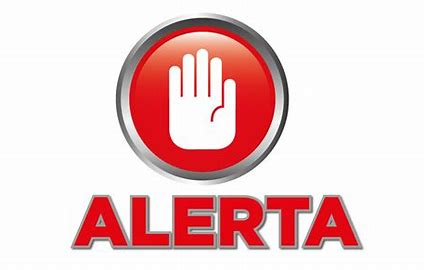

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import seaborn as sns
import warnings
import altair as alt
import nltk
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np

sns.set_style("whitegrid")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
df = pd.read_csv('News_dataset.csv',sep=';')

# Análise exploratória dos dados

In [3]:
df.head()

,File_Name,Content,Category,Complete_Filename
0,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...,business,001.txt-business
1,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...,business,002.txt-business
2,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...,business,003.txt-business
3,004.txt,High fuel prices hit BA's profits\n\nBritish A...,business,004.txt-business
4,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...,business,005.txt-business


## Número de artigos por classe

In [4]:
df.Category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: Category, dtype: int64

In [5]:
df2 = pd.DataFrame(df.groupby('Category').count()['Content']).reset_index()

bars = alt.Chart(df2).mark_bar(size=50).encode(
    x=alt.X('Category'),
    y=alt.Y('PercentOfTotal:Q', axis=alt.Axis(format='.0%', title='% of Articles')),
    color='Category'
).transform_window(
    TotalArticles='sum(Content)',
    frame=[None, None]
).transform_calculate(
    PercentOfTotal="datum.Content / datum.TotalArticles"
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
    #dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('PercentOfTotal:Q', format='.1%')
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "% of articles in each category",
)

alt.LayerChart(...)

## Análise sobre o tamanho dos artigos

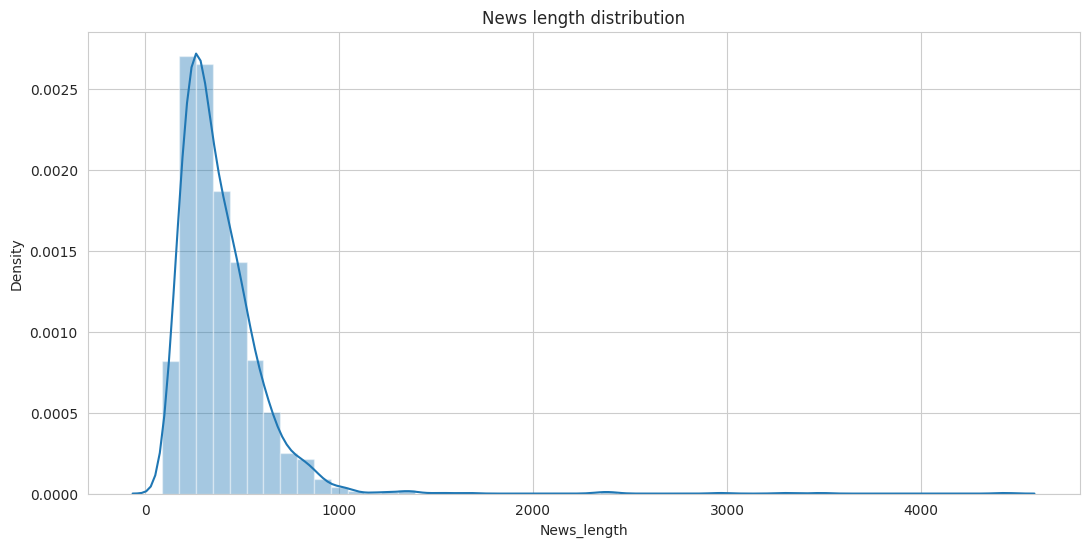

In [6]:
df['News_length'] =  [len(sentence.split()) for sentence in df['Content']]
plt.figure(figsize=(12.8,6))
sns.distplot(df['News_length']).set_title('News length distribution');

In [7]:
df['News_length'].describe()

count    2225.000000
mean      384.040449
std       238.174497
min        89.000000
25%       246.000000
50%       332.000000
75%       471.000000
max      4432.000000
Name: News_length, dtype: float64

In [20]:
#Remoção de caracteres especiais e números

input_str = 'This &is [an] example? {of} string. with.? punctuation!!!! 99' 

result = input_str.translate(str.maketrans('','', string.punctuation))
print(result)

result = result.translate(str.maketrans('','', string.digits))
print(result)

This is an example of string with punctuation 99
This is an example of string with punctuation 


**Cortando a calda para analizar melhor o histograma**


In [21]:
#número de artigos com mais de 1000 palavras
df[df['News_length'] > 1000].shape[0]

24

Text(0.5, 1.0, 'News length distribution')

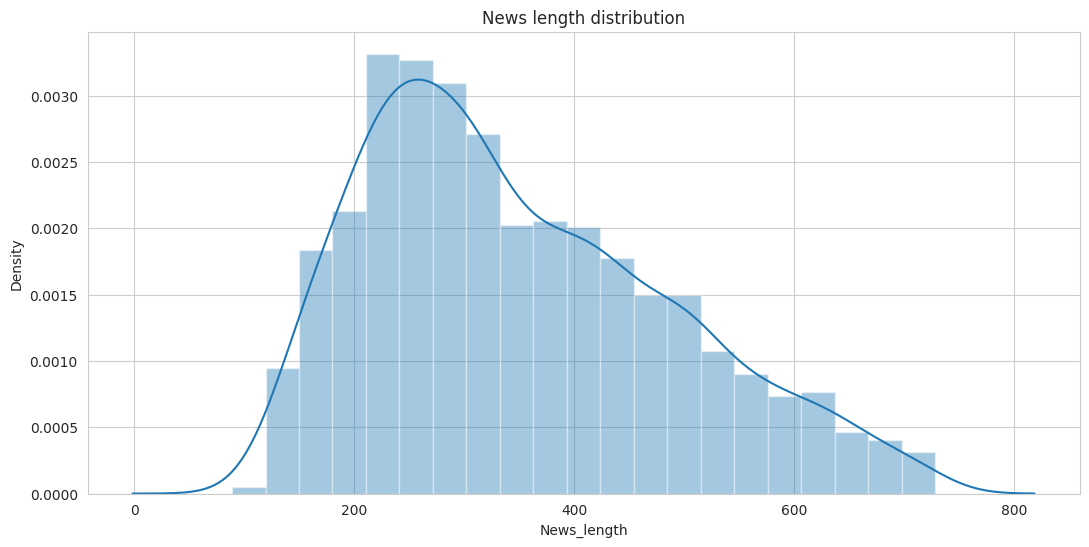

In [22]:
quantile_95 = df['News_length'].quantile(0.95)
df_95 = df[df['News_length'] < quantile_95]
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['News_length'], norm_hist = True).set_title('News length distribution')

**Distribuição do tamanho dos artigos por classe**

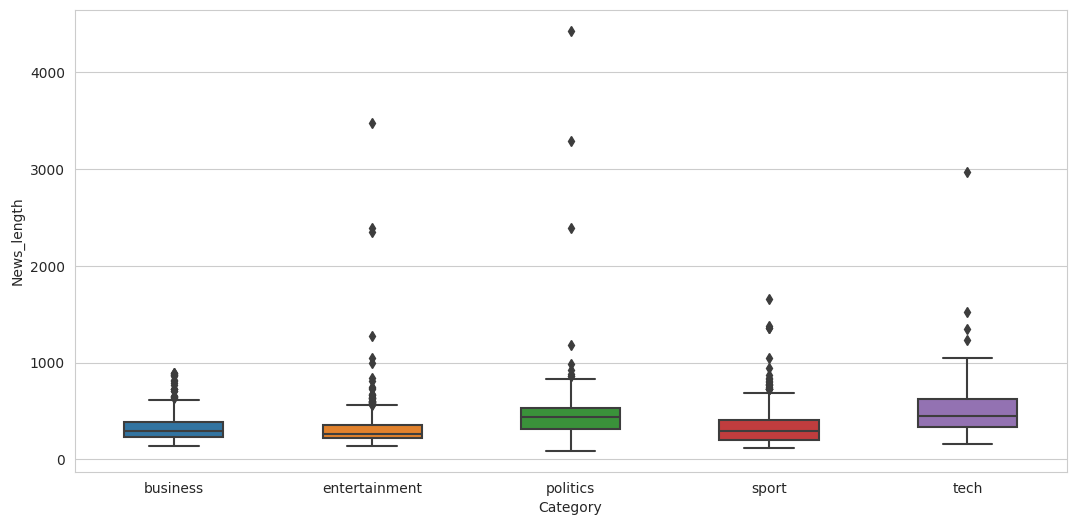

In [23]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='Category', y='News_length', width=.5);

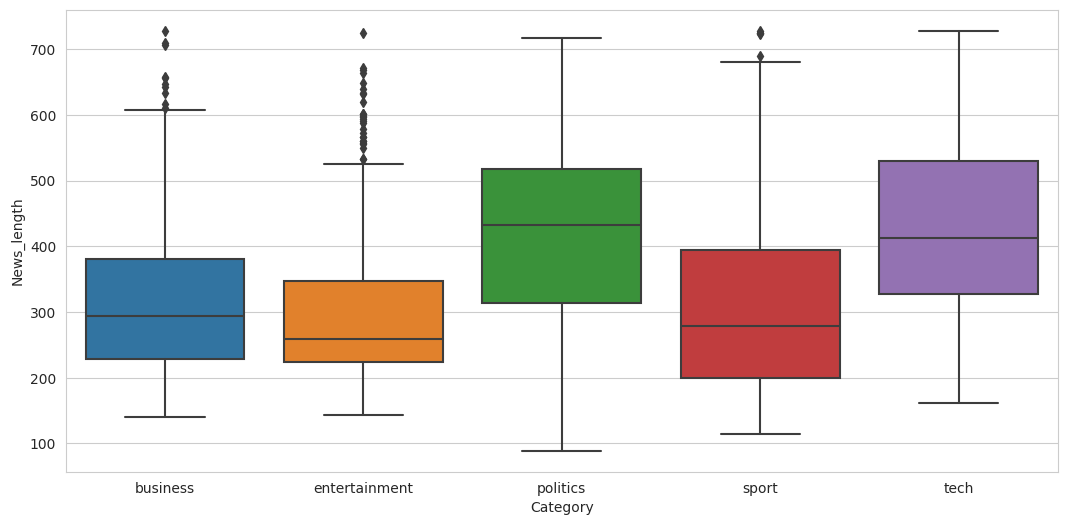

In [24]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='Category', y='News_length');

# Engenharia de atributos

In [27]:
df.loc[0]['Content']

'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to si

## 1. Limpeza dos dados

**1.1. Limpeza de caracteres especiais:**

  * \r
  * \n
  * pronomes pocessivos \'s (government's = government\'s)
  * sinais de pontuação





In [28]:
# \'s  \r  \n 
df['Content_Parsed_1'] = df['Content'].str.replace("\r", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\'s", "")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")


In [29]:
#Exemplo de remoção de sinais de pontuação e caracteres especiais

input_str = 'This & is [an] example? {of} string. with.? punctuation!!!!' 
punctuation = re.compile(r'[^A-Za-z0-9]+')
punctuation.sub(" ", input_str)


'This is an example of string with punctuation '

In [30]:
#Aplicando na base

df['Content_Parsed_1'] = [content.translate(str.maketrans('','', string.punctuation)) for content in df['Content_Parsed_1']]
df['Content_Parsed_1'] = [content.translate(str.maketrans('','', string.digits)) for content in df['Content_Parsed_1']]

In [31]:

print('Antes: \n'+ df.loc[0]['Content'] + '\n \n')

print('Depois: \n'+ df.loc[0]['Content_Parsed_1'])


Antes: 
Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to si

**1.2. Remoção de stopwords**

In [32]:
# baixando as listas de stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
# carregando a lista de stopwords em inglês
stop_words = list(stopwords.words('english'))
stop_words 

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [75]:
stop_words = [word.replace("'","") for word in stop_words]
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'youre',
 'youve',
 'youll',
 'youd',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'shes',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'thatll',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'fe

**1.3. Stemming ou  lematização**

***Stemming:*** Stemming é o processo de reduzir a inflexão em palavras às suas formas-raiz, como mapear um grupo de palavras para o mesmo radical, mesmo que o radical em si não seja uma palavra válida na linguagem

***Lematização:*** A lematização, ao contrário do Stemming, reduz as palavras flexionadas garantindo adequadamente que a palavra raiz pertence à linguagem. Na lematização, a palavra raiz é chamada de Lema. Um lema (plural lemmas ou lemmata) é a forma canônica, a forma de dicionário ou a forma de citação de um conjunto de palavras.

In [35]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [42]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import spacy
nltk.download('wordnet')

wnl = WordNetLemmatizer()
porter = PorterStemmer()
lancaster=LancasterStemmer()
snowball = SnowballStemmer(language="english")

word_list = ["friends", "amity", "studies", "studing", "destabilization","aardwolves","wedding"]
print("{0:20}{1:20}{2:20}{3:20}{4:20}{5:20}".format("Palavra","Porter Stemmer", "SnowballStemmer", "lancaster Stemmer","Wordnet_Substantivo","Wordnet_Verbo"))
print("")
for word in word_list:
    print("{0:20}{1:20}{2:20}{3:20}{4:20}{5:20}".format(word,porter.stem(word), snowball.stem(word), lancaster.stem(word), wnl.lemmatize(word,pos=wordnet.NOUN),wnl.lemmatize(word,pos=wordnet.VERB)))

Palavra             Porter Stemmer      SnowballStemmer     lancaster Stemmer   Wordnet_Substantivo Wordnet_Verbo       

friends             friend              friend              friend              friend              friends             
amity               amiti               amiti               am                  amity               amity               
studies             studi               studi               study               study               study               
studing             stude               stude               stud                studing             stud                
destabilization     destabil            destabil            dest                destabilization     destabilization     
aardwolves          aardwolv            aardwolv            aardwolv            aardwolf            aardwolves          
wedding             wed                 wed                 wed                 wedding             wed                 


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [76]:
nlp = spacy.load("en_core_web_sm")

#homenagem ao colunator ;D
func_lematizator = lambda x: " ".join([w.lemma_ for w in nlp(x) if w.text not in stop_words])

df['Content_Parsed_2'] = df['Content_Parsed_1'].apply(func_lematizator)

In [ ]:
func_stemmizator = lambda x: " ".join([lancaster.stem(w) for w in x.lower().split() if w not in stop_words])
df['Content_Parsed_2b'] = df['Content_Parsed_1'].apply(func_stemmizator)

In [63]:
df.loc[5]['Content']

'Japan narrowly escapes recession\n\nJapan\'s economy teetered on the brink of a technical recession in the three months to September, figures show.\n\nRevised figures indicated growth of just 0.1% - and a similar-sized contraction in the previous quarter. On an annual basis, the data suggests annual growth of just 0.2%, suggesting a much more hesitant recovery than had previously been thought. A common technical definition of a recession is two successive quarters of negative growth.\n\nThe government was keen to play down the worrying implications of the data. "I maintain the view that Japan\'s economy remains in a minor adjustment phase in an upward climb, and we will monitor developments carefully," said economy minister Heizo Takenaka. But in the face of the strengthening yen making exports less competitive and indications of weakening economic conditions ahead, observers were less sanguine. "It\'s painting a picture of a recovery... much patchier than previously thought," said Pa

In [62]:
df.loc[1]['Content_Parsed_1']

'Dollar gains on Greenspan speech  The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise  And Alan Greenspan highlighted the US government willingness to curb spending and rising household savings as factors which may help to reduce it In late trading in New York the dollar reached  against the euro from  on Thursday Market concerns about the deficit has hit the greenback in recent months On Friday Federal Reserve chairman Mr Greenspan speech in London ahead of the meeting of G finance ministers sent the dollar higher after it had earlier tumbled on the back of worsethanexpected US jobs data I think the chairman taking a much more sanguine view on the current account deficit than he taken for some time said Robert Sinche head of currency strategy at Bank of America in New York He taking a longerterm view laying out a set of conditions under which the current account deficit can improve t

In [64]:
df.loc[1]['Content_Parsed_2']

'dollar gain Greenspan speech   dollar hit high level euro almost three month Federal Reserve head say US trade deficit set stabilise   Alan Greenspan highlight US government willingness curb spending rise household saving factor may help reduce late trading New York dollar reach   euro   Thursday Market concern deficit hit greenback recent month Friday Federal Reserve chairman Mr Greenspan speech London ahead meeting G finance minister send dollar higher early tumble back worsethanexpected US job datum I think chairman take much sanguine view current account deficit take time say Robert Sinche head currency strategy Bank America New York take longerterm view lay set condition current account deficit improve year next   worry deficit concern China however remain China currency remains peg dollar US currency sharp fall recent month therefore make chinese export price highly competitive call shift Beijing policy fall deaf ear despite recent comment major chinese newspaper time ripe loose

In [65]:
df.loc[1]['Content_Parsed_2b']

'doll gain greensp speech doll hit highest level euro almost three month fed reserv head said us trad deficit set stabl al greensp highlight us govern wil curb spend ris household sav fact may help reduc lat trad new york doll reach euro thursday market concern deficit hit greenback rec month friday fed reserv chairm mr greensp speech london ahead meet g fin min sent doll high ear tumbl back worsethanexpect us job dat think chairm tak much sanguin view cur account deficit tak tim said robert sinch head cur strategy bank americ new york tak longerterm view lay set condit cur account deficit improv year next worry deficit concern chin howev remain chin cur remain peg doll us cur sharp fal rec month theref mad chines export pric high competit cal shift beid policy fal deaf ear despit rec com maj chines newspap tim rip loos peg g meet thought unlik produc mean mov chines policy meantim us fed reserv decid febru boost interest rat quart point six mov many month op diff europ rat halfpoint w

In [67]:
#Base tratada
df['Content_Parsed'] = df['Content_Parsed_2']

## 2. Codificação dos rótulos

In [68]:
category_codes = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}

In [78]:
# Mapeamento das categorias
df['Category_Code'] = df['Category']
df = df.replace({'Category_Code':category_codes})

In [79]:
df.head()

,File_Name,Content,Category,Complete_Filename,News_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_2b,Content_Parsed,Category_Code
0,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...,business,001.txt-business,421,Ad sales boost Time Warner profit Quarterly p...,ad sale boost Time Warner profit Quarterly p...,ad sal boost tim warn profit quart profit us m...,ad sale boost Time Warner profit Quarterly p...,0
1,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...,business,002.txt-business,384,Dollar gains on Greenspan speech The dollar h...,dollar gain Greenspan speech the dollar hit ...,doll gain greensp speech doll hit highest leve...,dollar gain Greenspan speech dollar hit high...,0
2,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...,business,003.txt-business,264,Yukos unit buyer faces loan claim The owners ...,Yukos unit buyer face loan claim the owner e...,yuko unit buy fac loan claim own embattl russ ...,Yukos unit buyer face loan claim owner embat...,0
3,004.txt,High fuel prices hit BA's profits\n\nBritish A...,business,004.txt-business,406,High fuel prices hit BA profits British Airwa...,high fuel price hit BA profit British Airway...,high fuel pric hit ba profit brit airway blam ...,high fuel price hit BA profit British Airway...,0
4,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...,business,005.txt-business,265,Pernod takeover talk lifts Domecq Shares in U...,pernod takeover talk lift Domecq share UK dr...,pernod takeov talk lift domecq shar uk drink f...,pernod takeover talk lift Domecq share UK dr...,0


## 3.  Divisão de conjuntos de treinamento e teste

In [80]:
X_train, X_test, y_train, y_test = train_test_split(df['Content_Parsed'], 
                                                    df['Category_Code'], 
                                                    test_size=0.15, 
                                                    random_state=1)

## 4. Transformação dos dados (representação de textos)


Alguns tipos

*   ***Count Vectors*** 
*   ***Boolean Vectors***
*   ***TF-IDF Vectors***
*   ***Word Embeddings***
*   ***Text / NLP based features***



### TF-IDF

O TF-IDF é uma pontuação que representa a importância relativa de um termo no documento e em todo o corpus. TF significa Term Frequency e IDF significa Frequência Inversa do Documento:

![alt text](https://cdn-images-1.medium.com/max/1000/0*oamFbfNAyVptRlLz.png)

O valor TF-IDF aumenta proporcionalmente ao número de vezes que uma palavra aparece no documento e é compensada pelo número de documentos no corpus que contém a palavra, o que ajuda a ajustar o fato de que algumas palavras aparecem com mais frequência em geral.

Também leva em conta o fato de que alguns documentos podem ser maiores do que outros ao normalizar o termo do TF (expressando, ao invés disso, frequências relativas de termos).

Esses dois métodos (Vetores de Contagem de Palavras e Vetores TF-IDF) são freqüentemente chamados de métodos de Bag of Words, uma vez que a ordem das palavras em uma sentença é ignorada.

**Parâmetros importantes**

* ngram_range: se queremos utilizar tokens simples ou compostos;
* max_df: número máximo de documentos que um token precisa ocorrer para ser considerado;
* min_df: número mínimo de documentos que um token precisa ocorrer para ser considerado;
* max_features: se diferente de None, cria um vocabulário de tamanho max_features com apenas com os tokens que ocorrem mais na base.
* strip_accents: remove acentos;
* stopwords: recebe a lista de stopwords para serem removidas (mais rápido que o método anteriormente apresentado).


Outros parâmetros: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [82]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = None

In [83]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=stop_words,
                        lowercase=True,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(1891, 5443)
(334, 5443)


Podemos agora utilizar o teste chi2 para identificar as palavras mais correlacionadas com cada classe.

In [84]:
from sklearn.feature_selection import chi2
import numpy as np

for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'business' category:
  . Most correlated unigrams:
. economy
. oil
. growth
. bank
. bn
  . Most correlated bigrams:
. analyst say
. bn bn

# 'entertainment' category:
  . Most correlated unigrams:
. actor
. singer
. award
. star
. film
  . Most correlated bigrams:
. film festival
. box office

# 'politics' category:
  . Most correlated unigrams:
. tory
. blair
. party
. election
. labour
  . Most correlated bigrams:
. tony blair
. mr blair

# 'sport' category:
  . Most correlated unigrams:
. rugby
. injury
. coach
. cup
. match
  . Most correlated bigrams:
. champions league
. six nations

# 'tech' category:
  . Most correlated unigrams:
. pc
. computer
. software
. technology
. user
  . Most correlated bigrams:
. let people
. mobile phone



## 5. Seleção de Atributos

In [85]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k=300)
features_train = selector.fit_transform(features_train, labels_train)
features_test = selector.transform(features_test)

print(features_train.shape)
print(features_test.shape)


(1891, 300)
(334, 300)


In [87]:
pd.DataFrame(features_test)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.148502,0.0,0.000000,0.112564,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.054223,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.067675,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.054760,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0


# Criação do Modelo


In [88]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer

score_metrics = {'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)}

df_estimators_scores = pd.DataFrame(columns=['Estimator', 'Cross-validation Scores', 'Test Set Scores'])
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores


## 1. Random Forest

In [89]:
from sklearn.ensemble import RandomForestClassifier

### 1.1. Ajuste de Parâmetros



In [90]:
rf_0 = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
print(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 8, 'verbose': 0, 'warm_start': False}


**Randomized Search Cross Validation**

In [91]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [92]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=5,
                                   scoring=score_metrics,
                                   refit='F1',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs =2)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
                   n_iter=5, n_jobs=2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=8, refit='F1',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'F1': 'f1_macro'},
                   verbose=1)

In [93]:
print("Os melhores hiperparâmetros encontrados com o Radom Search são:")
print(random_search.best_params_)
print("")
print("A macro F1 obtida com esses hiperparâmetros é:")
print(random_search.best_score_)

Os melhores hiperparâmetros encontrados com o Radom Search são:
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}

A macro F1 obtida com esses hiperparâmetros é:
0.9539968210751685


In [94]:
pd.DataFrame(random_search.cv_results_).T

,0,1,2,3,4
mean_fit_time,2.77592,3.102491,5.811666,4.030981,2.32989
std_fit_time,0.380951,0.241858,2.284913,2.251482,0.139476
mean_score_time,0.197049,0.200916,0.283176,0.140261,0.12815
std_score_time,0.052942,0.079959,0.020852,0.002925,0.022466
param_n_estimators,400,400,800,400,400
param_min_samples_split,2,2,10,10,2
param_min_samples_leaf,1,1,4,4,1
param_max_features,auto,auto,auto,sqrt,sqrt
param_max_depth,None,100,40,100,40
param_bootstrap,True,True,True,False,True


**Grid Search Cross Validation**

In [ ]:

bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1, n_jobs =2)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

print("Os melhores hiperparâmetros encontrados com o Radom Search são:")
print(grid_search.best_params_)
print("")
print("A acurácia média obtida com esses hiperparâmetros é:")
print(grid_search.best_score_)



In [96]:
results = random_search.cv_results_

In [97]:
best_rfc = random_search.best_estimator_ 
best_rfc

RandomForestClassifier(max_features='auto', n_estimators=400, random_state=8)

### 1.2. Treinamento e avaliação do modelo



In [98]:
best_scorer_index = np.nonzero(results['rank_test_F1'] == 1)[0][0]
best_scorer_index

0

In [99]:
best_rfc.fit(features_train, labels_train)
rfc_pred = best_rfc.predict(features_test)

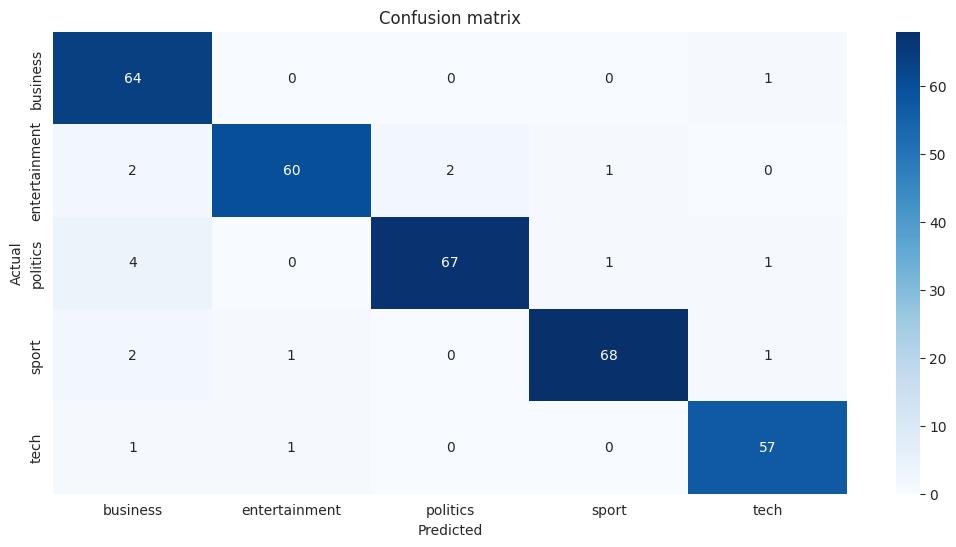

In [100]:
acc = accuracy_score(labels_test, rfc_pred)
f1 = f1_score(labels_test, rfc_pred, average='macro')
print(classification_report(labels_test,rfc_pred))

aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

In [101]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (results['mean_test_F1'][best_scorer_index], results['mean_test_Accuracy'][best_scorer_index]))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

Cross-validation scores
F1: 0.954 - Accuracy: 0.955 
---------------------------
Test scores
F1: 0.946 - Accuracy: 0.946 


In [102]:
d = {
     'Estimator': 'Random Forest',
     'Cross-validation Scores': (round(results['mean_test_F1'][best_scorer_index],3), round(results['mean_test_Accuracy'][best_scorer_index],3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)

In [103]:
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest,"(0.954, 0.955)","(0.946, 0.946)"


## 2. Support Vector Machine


![](https://www.researchgate.net/profile/Elisa_Aleman_Carreon/publication/323137738/figure/fig2/AS:735529951842304@1552375414012/2D-example-of-the-Linear-SVM-classification-The-linear-kernel-for-the-SVM-classification.png)



In [104]:
from sklearn import svm

### 2.1. Ajuste de Parâmetros

In [105]:
svc_0 =svm.SVC(random_state=8)

print('Parameters currently in use:\n')
pprint(svc_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


Vamos ajustar os seguintes parâmetros:

* C: Tolerância a erros de classificação;
* kernel: Especifica o Kernel;
* gamma: coeficiente do kernel (aplicável para os kernels ‘rbf’, ‘poly’ e ‘sigmoid’);
* degree: quando o kernel for polinomial, determina o grau.

**Parâmetro Kernel**

Define uma função de transformação dos dados de modo a representá-los em um conjunto de dimensões diferente do original a fim de melhor separá-los

![alt text](https://blog-c7ff.kxcdn.com/blog/wp-content/uploads/2017/02/kernel.png)

**Parâmetro C**

Tolerância a erros de classificação em prol da maximização da margem de decisão

![alt text](https://i.stack.imgur.com/GbW5S.png)

**Parâmetro gamma**

Gama define o alcance da influência de um único exemplo de treinamento na definição dos limites de decisão. 

Um gama baixo levará em consideração exemplos de treinamento que estão mais longe do limite de decisão e um gama alto considerará os pontos mais próximos do limite de decisão.

Gama alto =  overfitting
Gama baixo = underfitting

gamma = 0.001

![alt text](http://wiki.eigenvector.com/images/thumb/7/73/C1g0p001.png/400px-C1g0p001.png)

gamma = 0.01

![alt text](http://wiki.eigenvector.com/images/thumb/f/f6/C1g0p01.png/400px-C1g0p01.png)

gamma = 0.1

![alt text](http://wiki.eigenvector.com/images/thumb/1/1b/C1g10.png/400px-C1g10.png)

Mais variações: http://wiki.eigenvector.com/index.php?title=Svmda

**Parâmetro degree**

Quanto maior o grau da função polinomial, maior a flexibilidade do limite de decisão.

![alt text](https://www.researchgate.net/profile/Cheng_Soon_Ong/publication/23442384/figure/fig12/AS:341444054274063@1458418014823/The-effect-of-the-degree-of-a-polynomial-kernel-The-polynomial-kernel-of-degree-1-leads.png)



In [106]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


**Randomized Search Cross Validation**

In [107]:
# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=5,
                                   scoring=score_metrics,
                                   refit='F1',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs =2)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=SVC(random_state=8), n_iter=5, n_jobs=2,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   random_state=8, refit='F1',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'F1': 'f1_macro'},
                   verbose=1)

In [108]:
print("Os melhores hiperparâmetros encontrados com o Radom Search são:")
print(random_search.best_params_)
print("")
print("A macro F1 obtida com esses hiperparâmetros é:")
print(random_search.best_score_)

Os melhores hiperparâmetros encontrados com o Radom Search são:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

A macro F1 obtida com esses hiperparâmetros é:
0.31434258620224537


In [109]:
results = random_search.cv_results_

best_svm = random_search.best_estimator_ 
best_svm

SVC(C=0.01, degree=4, gamma=10, kernel='poly', probability=True, random_state=8)

In [110]:
results

{'mean_fit_time': array([3.5669469 , 3.75897598, 6.05671295, 3.59985534, 3.25404072]),
 'std_fit_time': array([0.27913364, 0.4722674 , 1.46327855, 0.50329422, 0.61947278]),
 'mean_score_time': array([0.18321149, 0.34189359, 0.47430372, 0.24776936, 0.15675028]),
 'std_score_time': array([0.00828859, 0.11873319, 0.00404655, 0.0543065 , 0.03800817]),
 'param_probability': masked_array(data=[True, True, True, True, True],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['poly', 'linear', 'rbf', 'poly', 'poly'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.001, 0.0001, 0.0001, 10, 10],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_degree': masked_array(data=[4, 3, 4, 4, 1],
              mask=[False, False, False, False, False],
 

### 2.2. Treinamento e avaliação do modelo

In [111]:
best_scorer_index = np.nonzero(results['rank_test_F1'] == 1)[0][0]
best_scorer_index

3

In [112]:
best_svm.fit(features_train, labels_train)
svm_pred = best_svm.predict(features_test)


In [113]:
acc = accuracy_score(labels_test, svm_pred)
f1 = f1_score(labels_test, svm_pred, average='macro')
print(classification_report(labels_test,svm_pred))

              precision    recall  f1-score   support

           0       0.27      1.00      0.42        65
           1       1.00      0.17      0.29        65
           2       1.00      0.23      0.38        73
           3       0.98      0.65      0.78        72
           4       1.00      0.25      0.41        59

    accuracy                           0.46       334
   macro avg       0.85      0.46      0.46       334
weighted avg       0.85      0.46      0.46       334



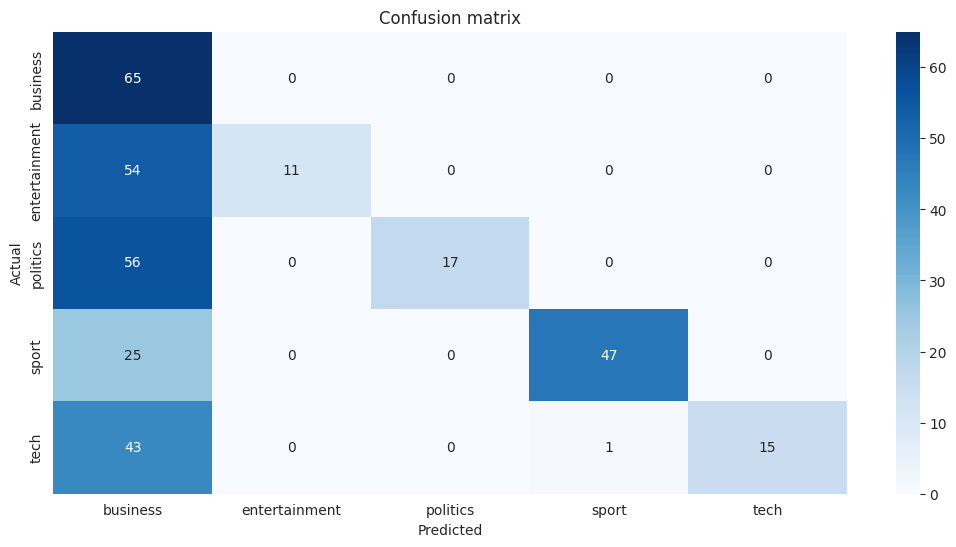

In [114]:
aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, svm_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

In [115]:
labels_test.value_counts()

2    73
3    72
0    65
1    65
4    59
Name: Category_Code, dtype: int64

In [116]:
aux_df['Category']

0            business
510     entertainment
896          politics
1313            sport
1824             tech
Name: Category, dtype: object

In [117]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (results['mean_test_F1'][best_scorer_index], results['mean_test_Accuracy'][best_scorer_index]))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

Cross-validation scores
F1: 0.314 - Accuracy: 0.378 
---------------------------
Test scores
F1: 0.456 - Accuracy: 0.464 


In [118]:
['Estimator', 'Cross-validation Scores', 'Test Set Scores']

d = {
     'Estimator': 'SVM',
     'Cross-validation Scores': (round(results['mean_test_F1'][best_scorer_index],3), round(results['mean_test_Accuracy'][best_scorer_index],3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)

df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest,"(0.954, 0.955)","(0.946, 0.946)"
1,SVM,"(0.314, 0.378)","(0.456, 0.464)"


In [119]:
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest,"(0.954, 0.955)","(0.946, 0.946)"
1,SVM,"(0.314, 0.378)","(0.456, 0.464)"


## 3. Multinomial Naïve Bayes

Digamos que estamos trabalhando no diagnóstico de uma nova doença, e que fizemos testes em 100 pessoas distintas.

Após coletarmos a análise, descobriu-se que:

* 100 pessoas realizaram o teste.
* 20% das pessoas que realizaram o teste possuíam a doença.
* 90% das pessoas que possuíam a doença, receberam positivo no teste.
* 30% das pessoas que não possuíam a doença, receberam positivo no teste.

Se uma nova pessoa realizar o teste e receber um resultado positivo, qual a probabilidade de ela possuir a doença?

![alt text](https://annalloyd.files.wordpress.com/2019/03/bayes-1.png?w=635&h=391)

**Solução:**

* P(doença|positivo) = 0,2 * 0,9
* P(doença|positivo) = 0,18

* P(não doença|positivo) = 0,8 * 0,3
* P(não doença|positivo) = 0,24

Após isso precisamos normalizar os dados, para que a soma das duas probabilidades resulte 1 (100%).

Para isso, dividimos o resultado pela soma das duas probabilidades.


P(doença|positivo) = 0,18/(0,18+0,24) = 0,4285

P(não doença|positivo) = 0,24/(0,18+0,24) = 0,5714


Assim sendo, se uma pessoa realizar o teste e receber um resultado positivo, a probabilidade de ela possuir a doença é de 57,14%


**Tipos de Naive bayes no sklearn**

* Bernoulli:  para atributos binários;
* Multinomial: atributos categóricos ou de contagem (funciona bem para contagens fracionárias como o TF-IDF);
* Gaussian: ideal para quando todos os atributos são contínuos, porém assume que a distribuição desses atributos é normal.

Fonte: https://www.organicadigital.com/seeds/algoritmo-de-classificacao-naive-bayes/


### E para texto??

P(I have huge respect for women) = P(I) × P(have) × P(huge) × P(respect) × P(for) × P(women)

P(I have huge respect for women|Trump) = P(I|Trump) × P(have|Trump) × P(huge|Trump) × P(respect|Trump) × P(for|Trump) × P(women|Trump)

P(I have huge respect for women|NotTrump) = P(I|NotTrump) × P(have|NotTrump) × P(huge|NotTrump) × P(respect|NotTrump) × P(for|NotTrump) × P(women|NotTrump)

**E se P(I) = 0?**

Parâmetro alpha 

In [120]:
from sklearn.naive_bayes import MultinomialNB 

### 3.1. Ajuste de Parâmetros


In [121]:
mnbc = MultinomialNB()
mnbc

MultinomialNB()

Aqui vamos utilizar o valor padrão de Alpha (indicando que deseja-se utilizar a suavização de Laplace)

### 3.2. Treinamento e avaliação do modelo

In [122]:
from sklearn.model_selection import cross_validate

In [124]:
scores = cross_validate(mnbc, features_train, labels_train, scoring=score_metrics, cv=3, return_train_score=True)

In [125]:
print(scores.keys())
print(scores['test_F1'])  

dict_keys(['fit_time', 'score_time', 'test_F1', 'train_F1', 'test_Accuracy', 'train_Accuracy'])
[0.94889202 0.96120029 0.93435383]


              precision    recall  f1-score   support

           0       0.88      0.98      0.93        65
           1       0.98      0.89      0.94        65
           2       1.00      0.92      0.96        73
           3       0.96      0.99      0.97        72
           4       0.92      0.95      0.93        59

    accuracy                           0.95       334
   macro avg       0.95      0.95      0.95       334
weighted avg       0.95      0.95      0.95       334



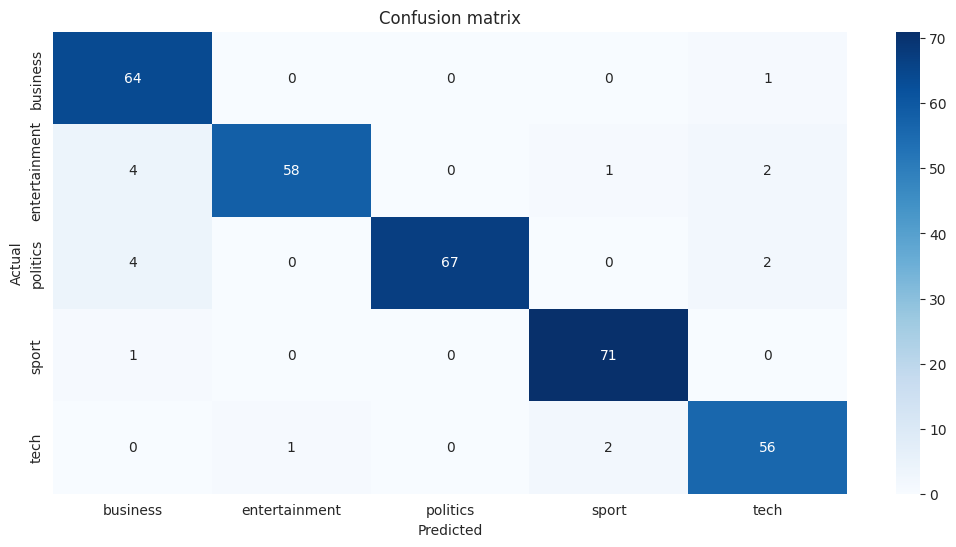

In [126]:
mnbc.fit(features_train, labels_train)
mnbc_pred = mnbc.predict(features_test)

acc = accuracy_score(labels_test, mnbc_pred)
f1 = f1_score(labels_test, mnbc_pred, average='macro')
print(classification_report(labels_test,mnbc_pred))

aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, mnbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

In [127]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (round(np.mean(scores['test_F1']),3), round(np.mean(scores['test_Accuracy']),3)))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

Cross-validation scores
F1: 0.948 - Accuracy: 0.949 
---------------------------
Test scores
F1: 0.945 - Accuracy: 0.946 


In [128]:
d = {
     'Estimator': 'MultinomialNB',
     'Cross-validation Scores': (round(np.mean(scores['test_F1']),3), round(np.mean(scores['test_Accuracy']),3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)


In [129]:
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest,"(0.954, 0.955)","(0.946, 0.946)"
1,SVM,"(0.314, 0.378)","(0.456, 0.464)"
2,MultinomialNB,"(0.948, 0.949)","(0.945, 0.946)"


# Análise do modelo


Vamos escolher o modelo gerado com o algoritmo Naive Bayes por ter alcançado os melhores indicadores.

Apesar de a acurácia e a medida f1 terem alcançado valores próximos de 1, ainda existem erros de classificação. Vamos agora analisar esses erros para entender esse comportamento.

In [134]:
predictions = mnbc.predict(features_test)

Vamos criar o dataframe do conjunto de testes com as categorias reais e previstas:

In [135]:
# Category mapping dictionary
category_codes = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}

category_names = {
    0: 'business',
    1: 'entertainment',
    2: 'politics',
    3: 'sport',
    4: 'tech'
}

# Indexes of the test set
index_X_test = X_test.index

# We get them from the original df
df_test = df.loc[index_X_test]

# Add the predictions
df_test['Prediction'] = predictions

# Clean columns
df_test = df_test[['Content', 'Category', 'Category_Code', 'Prediction']]

# Decode
df_test['Category_Predicted'] = df_test['Prediction']
df_test = df_test.replace({'Category_Predicted':category_names})

# Clean columns again
df_test = df_test[['Content', 'Category', 'Category_Predicted']]

In [132]:
df_test.head()

,Content,Category,Category_Predicted
1664,Wood - Ireland can win Grand Slam\n\nFormer ca...,sport,sport
1347,Collins banned in landmark case\n\nSprinter Mi...,sport,sport
432,Cairn Energy in Indian gas find\n\nShares in C...,business,business
1435,England's defensive crisis grows\n\nEngland's ...,sport,sport
1374,Brizzel to run AAA's in Sheffield\n\nBallymena...,sport,sport


Vamos pegar os artigos classificados incorretamente:

In [136]:
condition = (df_test['Category'] != df_test['Category_Predicted'])

df_misclassified = df_test[condition]

df_misclassified.head(5)

,Content,Category,Category_Predicted
1004,UK firms 'embracing e-commerce'\n\nUK firms ar...,politics,tech
683,X Factor show gets second series\n\nTV talent ...,entertainment,sport
766,Row threatens Hendrix museum plan\n\nProposals...,entertainment,business
535,UK's National Gallery in the pink\n\nThe Natio...,entertainment,business
1086,Short attacks US over tsunami aid\n\nFormer Ca...,politics,business


In [137]:
df_misclassified.Category_Predicted.value_counts()

business         9
tech             5
sport            3
entertainment    1
Name: Category_Predicted, dtype: int64

In [138]:
df_misclassified[df_misclassified.Category_Predicted == "business"].Category.value_counts()

entertainment    4
politics         4
sport            1
Name: Category, dtype: int64

Vamos pegar uma amostra de 3 artigos. Vamos definir uma função para tornar esse processo mais rápido:

In [139]:
def output_article(row_article):
    print('Actual Category: %s' %(row_article['Category']))
    print('Predicted Category: %s' %(row_article['Category_Predicted']))
    print('-------------------------------------------')
    print('Text: ')
    print('%s' %(row_article['Content']))

Selecionar três índices aleatoriamente:

In [140]:
import random

random.seed(0)
list_samples = random.sample(list(df_misclassified.index), 3)
list_samples

[242, 1264, 683]

**Texto 1**

In [141]:
output_article(df_misclassified.loc[list_samples[0]])

Actual Category: business
Predicted Category: tech
-------------------------------------------
Text: 
Making your office work for you

Our mission to brighten up your working lives continues - and this time, we're taking a long hard look at your offices.

Over the next few months, our panel of experts will be listening to your gripes about where you work, and suggesting ways to make your workspace more efficient, more congenial or simply prettier. This week, we're hearing from Marianne Petersen, who is planning to convert a barn in Sweden into a base for her freelance writing work. Click on the link under her photograph to read her story, and then scroll down to see what the panel have to say. And if you want to take part in the series, go to the bottom of the story to find out how to get in touch.

Working from home presents a multitude of challenges. Understanding your work personality allows you to work in terms of your own style. Do you feel confident about your work output without

**Texto 2**

In [142]:
output_article(df_misclassified.loc[list_samples[1]])

Actual Category: politics
Predicted Category: business
-------------------------------------------
Text: 
BAA support ahead of court battle

UK airport operator BAA has reiterated its support for the government's aviation expansion plans to airports throughout the country.

The comments come a day ahead of a High Court challenge by residents' groups and local councils to the government's White Paper. The judicial review will centre on government plans for expansion at Heathrow, Stansted and Luton airports. BAA, which operates all three, said it was consulting with local communities. "We are...consulting on voluntary compensation schemes which go beyond our statutory obligations," a BAA spokesman said.

Groups challenging the plans include Stop Stansted Expansion, Heathrow anti-noise campaigners HACAN Clearskies and the London boroughs of Hillingdon and Wandsworth. At Heathrow, Gatwick, Edinburgh and Glasgow airports, BAA launched a series of consultations on blight to properties from t

**Texto 3**

In [143]:
output_article(df_misclassified.loc[list_samples[2]])

Actual Category: entertainment
Predicted Category: sport
-------------------------------------------
Text: 
X Factor show gets second series

TV talent show The X Factor is to return for a second series after being recommissioned by ITV.

Judges Simon Cowell, Louis Walsh and Sharon Osbourne are in discussions to sign up for the new series. The final of the first series will take place on 11 December. Last Saturday's show was beaten in the ratings by the BBC's Strictly Come Dancing. "Working on the X Factor has been a blast... I predict series two will be even better," said Cowell. "I think the production team have done an amazing job," he added.

The Pop Idol-style show votes off a group or contestant every week - the two that receive the lowest public vote have to perform a second time before the judges make a final decision. Rowetta Satchell, Steve Brookstein, Tabby Callaghan and group G4 are the remaining finalists. ITV's controller of entertainment, Claudia Rosencrantz, said she ha